### For an implementation of HNSW we first need to import the data AND an encoder.
### Luckily AutoEncoder.ipynb has trained an encoder using an autoencoder.

In [198]:
# Load FashionMNIST Dataset
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np
import importlib
# Reload custom modules in case of refresh
import custom_models
importlib.reload(custom_models)
from custom_models import AutoEncoder, Linspace
from heapq import heapify, heappush, heappop, nsmallest, merge
from random import randrange
from time import time

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

In [199]:

auto_enc_path = "autoencoder.model"

autoenc = torch.load(auto_enc_path)
autoenc.eval()
print(autoenc)

AutoEncoder(
  (Encoder): Linspace(
    (full_model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=556, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=556, out_features=328, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=328, out_features=100, bias=True)
        (1): ReLU()
      )
    )
  )
  (Decoder): Linspace(
    (full_model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=100, out_features=328, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=328, out_features=556, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=556, out_features=784, bias=True)
        (1): ReLU()
      )
    )
  )
  (full_model): Sequential(
    (0): Linspace(
      (full_model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=784, out_features=556

In [201]:
# Extract the Encoder from AutoEncoder
encoder = autoenc.Encoder
decoder = autoenc.Decoder

in_img, in_label = training_data[50301]
flat = in_img.reshape(-1, 28 * 28)
mid = encoder(flat)
pred = decoder(mid) #autoenc(flat)
out_img = pred.reshape(-1, 28, 28)


# Reshape Encoded image to display in grid fmt
mid_img = mid.reshape(-1, 10, 10)
print(mid)

tensor([[0.0000, 0.0000, 1.2543, 0.0000, 0.0000, 0.3116, 0.0000, 0.3030, 0.7631,
         0.8196, 0.0000, 1.7609, 0.0000, 0.2291, 0.0000, 0.0000, 0.0000, 1.0881,
         2.2962, 0.3158, 0.0000, 0.5451, 0.0000, 0.5175, 0.6415, 0.0000, 1.8303,
         0.7220, 0.0000, 0.0000, 2.0184, 0.5886, 0.5796, 0.0000, 0.7984, 1.3519,
         0.6037, 0.0000, 0.1794, 0.0000, 0.0000, 0.1343, 1.1280, 0.4201, 0.0000,
         0.0000, 0.5975, 0.4980, 1.4624, 0.6495, 0.0959, 0.0000, 0.3794, 0.0000,
         0.0000, 0.4647, 0.7303, 0.7141, 0.7748, 0.8357, 0.0000, 0.1220, 0.0000,
         0.0000, 0.2866, 0.0000, 1.8208, 0.0000, 0.2873, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.9418, 0.0000, 0.0000, 0.0000, 0.0000, 0.3556, 0.5633,
         0.0000, 0.0000, 0.3923, 0.0000, 0.0000, 0.9143, 0.0000, 0.1469, 0.0000,
         1.4023, 0.8872, 0.7862, 1.7954, 0.0000, 0.0000, 0.0000, 0.4692, 0.0000,
         0.0607]], grad_fn=<ReluBackward0>)


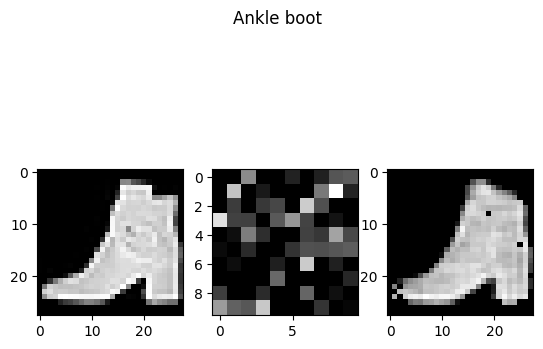

In [202]:
f, ax = plt.subplots(1,3)
# display input img
ax[0].imshow(in_img.squeeze(), cmap='gray')
# display output img
ax[2].imshow(out_img.detach().squeeze(), cmap='gray')
# display mid img
ax[1].imshow(mid_img.detach().squeeze(), cmap='gray')
label_idx = np.argmax(in_label).detach().numpy()
f.suptitle(class_names[label_idx])
plt.show()

Let's try building some KNN data structures/ Vector databases in which we can throw in encoded images

In [228]:
# Attempt 1: Navigable small world.
class NSW():

    def _greedy_search_helper(self, curr, vec, visited, results, k=3):
        # given a query vector, search the graph from the current node idx

        # mark curr visited
        visited.add(curr)
        # dereference data to get curr vector
        curr_vec = self.data[curr]
        # baseline distance determines if we're at a local minima
        baseline_dist = self.sim(curr_vec, vec)
        # dereference curr to get neighbors
        neighbors = self.graph[curr]
        neighbor_idx = [n[1] for n in neighbors]

        # store the neighbor's distance and index in neighbor_dist
        neighbor_dist = [(self.sim(self.data[n],vec), n)  for n in neighbor_idx]
        # neighbor_dist = []
        # for n in neighbor_idx:
        #     print(n)
        #     v1, v2 = self.data[n], vec
        #     print(v1.shape, v2.shape)
        #     s = self.sim(v1, v2)
        #     print(s)
        #     neighbor_dist.append(s,n)
        # heapify list
        heapify(neighbor_dist)
        # neighbor_dist[0][0] is the distance of the closest neighbor. 
        # If it's larger than baseline, then return, because we've hit a local minima
        if (neighbor_dist[0][0] > baseline_dist):
            return nsmallest(k,results)
        
        # Otherwise find the next unvisited node
        nearest = curr
        while nearest in visited and len(neighbor_dist):
            nearest = heappop(neighbor_dist)
            heappush(results, nearest)
            pass
        
        # If visited all neighbors, we can cancel the search, otherwise continue.
        if nearest:
            return self._greedy_search_helper(nearest[1], vec, visited, results, k)
        else:
            return nsmallest(k,results)

        pass

    def _greedy_search(self, vec, k=3):
        # Initialize visited as empty
        visited = set()
        # Initialize results as first k values in data
        results = [(self.sim(self.data[I], vec), self.root) for I in range(k)]
        # call helper function from the root
        return self._greedy_search_helper(self.root, vec, visited, results)

    def _conn(self, ida, idb): # idx of two graph members.
        # make sure graph is accessible.
        assert ida < len(self.data), f"index of conn is out of range ({ida} >= {len(self.data)})"
        assert idb < len(self.data), f"index of conn is out of range ({idb} >= {len(self.data)})"
        # Get distance by dereferencing ids
        veca, vecb = self.data[ida], self.data[idb]
        dist = self.sim(veca, vecb)
        # push to both nodes' adj lists (using heaps!)
        heappush(self.graph[ida], (dist, idb))
        heappush(self.graph[idb], (dist, ida))

    def __init__(
            self,
            M = 8,
            theta = 0,
            sim = F.cosine_similarity, 
            root = None):
        # Use cosine similarity by default
        self.sim = sim
        # Root node will always begin the search
        self.root = None
        # Dim must always be agreed upon (only initialized on first vector)
        self.dim = None
        # Master dataset
        self.data = []
        # Graph will define graph search
        self.graph = []
        # Let M be the maximum number of allowed connections 
        self.M = M
        # Let m be the minimum number of allowed connections
        self.m = M // 2
        # Let theta be the number of times we perform a random search before returning KNN
        self.theta = theta
        assert theta >= 0, "Please enter a valid value of theta (int >= 0)"
        # If a root vector was specified, then we can start off by initializing root and dim
        if root:
            self.insert(root)
        pass

    def insert(self, vec):
        # Insert vec into data structure
        if len(self.data) == 0:
            # Add element to data list and graph.
            self.data.append(vec)
            self.graph.append([])
            # Set element to root, determine dimensions of data.
            self.root = 0
            self.dim  = vec.shape
            return
        
        # Make sure dimensions agree
        assert self.dim == vec.shape, f"Dimensions of vector must match data structure: expected {self.dim}, got {vec.shape}"

        # push into graph
        idx = len(self.data) # this node's idx will be idx.
        self.data.append(vec)
        self.graph.append([])

        # If the dataset is less than M (number of connections to be made), connect to root
        if len(self.data) < self.m:
            self._conn(self.root, idx)
        else:
            # connect the m nearest neighbors of the vector, making sure that we only keep the best self.M nodes.
            knn = self._greedy_search(vec, k=self.m)
            for _ , node in knn:
                self._conn(node, idx)

        
        # sanity check!
        assert len(self.data) == len(self.graph), f"data len != graph len ({len(self.data)}, {len(self.graph)})"
        self.sanity_check()
        pass

    def lookup(self, vec, k = 3, dist=False):
        if len(self.data) < k:
            return self.data
        else:
            self.sanity_check()
        # Perform K Nearest neighbor search from root
        final = self._greedy_search(vec, k)
        # Perform additional searches from random starting nodes
        for i in range(self.theta):
            start = randrange(len(self.data))
            res = self._greedy_search(start, k)
            final = nsmallest(k,merge(final, res))

        dist_list = [d[0] for d in final]
        idx_list = [d[1] for d in final]
        data_list = [self.data[i] for i in idx_list]
        if dist:
            return data_list, dist_list
        else:
            return data_list
    
    def sanity_check(self):
        # Make sure the graph has no over or under-connected nodes!
        for i,g in enumerate(self.graph):
            assert len(g) > 0, f"graph element {i} has no neigbours after {len(self.data)} inserts!"
        return



In [229]:
size = len(training_data)
print(size)

60000


In [243]:
# initialize NSW with random values.
euclidean = lambda t1, t2 : (t1 - t2).pow(2).sum().sqrt()
nsw = NSW(sim=euclidean)
# Benchark NSW against size of dataset.
def fill_db(db, num_items):
    def gen_random_query():
        random_query = torch.tensor( # convert to tensor
        np.maximum(0, # apply relu
            np.random.uniform( # uniform from -1 to 1
                low=-1.0,
                high=1.0,
                size=(1,100)))) # encoding size
        return random_query

    insert_times = []
    db_sizes, query_times = [], []
    # shuffle training data.
    for i in (t := trange(num_items)):
        query_img, query_label = training_data[i]
        query_flat = query_img.reshape(-1, 28 * 28)
        query_enc = encoder(query_flat)
        # time inserts as size increases
        start_time = time()
        db.insert(query_enc)
        end_time = time()
        insert_time = end_time - start_time
        insert_times.append(insert_time)
        # Monitor query time every 100 steps
        if i % 100 == 0:
            start_time = time()
            for _ in range(1000):
                r = gen_random_query()
                _ = db.lookup(r, k = 3)
            end_time = time()
            query_time = end_time - start_time
            query_times.append(query_time)
            db_sizes.append(i)
        t.set_description(f'Curr query time {query_time:.2E}')
    return insert_times, query_times, db_sizes
insert_times, query_times, db_sizes = fill_db(nsw, 500)

Curr query time 6.98E-03:   0%|          | 0/500 [00:00<?, ?it/s]

Curr query time 9.79E+00: 100%|██████████| 500/500 [00:27<00:00, 17.93it/s]


Text(0.5, 0, 'DB size')

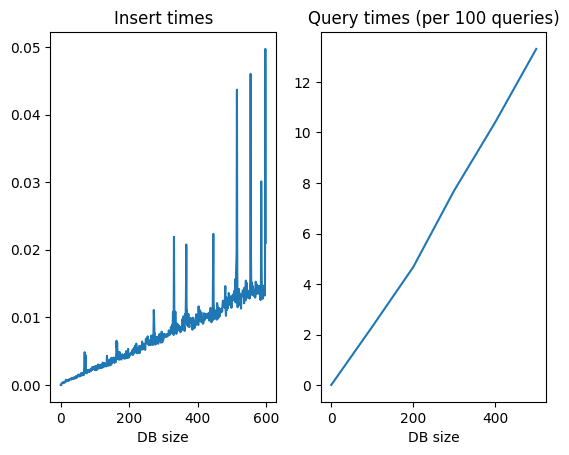

In [236]:
f, ax = plt.subplots(1,2) 
# insert times
ax[0].plot(insert_times)
ax[0].set_title('Insert times')
ax[0].set_xlabel('DB size')
# query times
ax[1].plot(db_sizes, query_times)
ax[1].set_title('Query times (per 100 queries)')
ax[1].set_xlabel('DB size')

torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


Text(0.5, 1.0, 'neighbor 3 (dist=4.88E+00)')

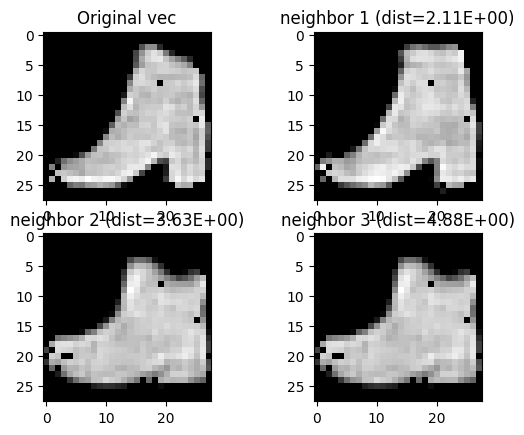

In [239]:
def plot_encoded(axis, vec, decoder):
    out = decoder(vec)
    out_img = out.reshape(-1, 28, 28)
    out_img = out_img.detach().squeeze()
    print(out_img.shape)
    axis.imshow(out_img, cmap='gray')
    pass
neighbors, dist = nsw.lookup(mid, dist=True)
f, ax = plt.subplots(2,2)
# OG
plot_encoded(ax[0][0], mid, decoder)
ax[0][0].set_title('Original vec')
# neighbors
plot_encoded(ax[0][1], neighbors[0], decoder)
ax[0][1].set_title(f'neighbor 1 (dist={dist[0]:.2E})')
plot_encoded(ax[1][0], neighbors[1], decoder)
ax[1][0].set_title(f'neighbor 2 (dist={dist[1]:.2E})')
plot_encoded(ax[1][1], neighbors[2], decoder)
ax[1][1].set_title(f'neighbor 3 (dist={dist[2]:.2E})')


In [241]:
class LSHTable():

    def hash(self, ps, vec):
        # given a planeset index and vector, generate and return the hash.
        planes = self.planesets[ps]
        proj = vec.T @ planes
        signs = torch.sign(proj).detach().squeeze()
        h = 0
        for i in range(signs.shape[0]):
            h += (2 ** i) * signs[i]
        return h

    def exhaustive_search(self, candidates, vec):
        dist, i =

    def __init__(self, P = 8, H = 3, dim=(1, 100), sim=):
        # dimensions of vector must be known before initialization
        self.dim = dim[1]
        # let P = the number of planes that will be applied to each vector
        self.P = P
        # Let H = number of hashes generated
        self.H = H
        # Create H sets of planes to generate hashes.
        self.planesets = [torch.rand(self.dim, self.P) for _ in range(self.H)]
        # use data list, hash list in order to rehash if necessary.
        self.data, self.hashes = [], []
        # Initialize empty dictionary
        self.vec_dict = dict()
        pass

    def add(self, vec):
        # new index is the length of data list before insertion
        new_idx = len(self.data)
        self.data.append(vec)
        self.hashes.append([])
        for p in range(self.H):
            h = self.hash(p, vec)
            print(f'Generated hash {hex(hash)}')
            self.hashes[new_idx].append(h)
        # Add index to dictionary based on all hashes.
        for h in self.hashes[new_idx]:
            if h not in self.vec_dict:
                self.vec_dict[h] = []
            self.vec_dict[h].append(new_idx)        
        pass

    def lookup(self, vec):
        # Compute hashes 
        hashes = []
        for p in range(self.H):
            h = self.hash(p, vec)
            print(f'Generated hash {hex(hash)}')
            hashes.append(h)
        candidates = []
        for h in hashes:
            candidates += self.vec_dict[h] if h in self.vec_dict else []
        
        
        pass

63.0
